In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# `PROBLEM STATEMENT`

This is Classification with Localization problem and i will use portion of CALTECH dataset

# `STEP 0: IMPORTING CORE LIBRARIES`

In [1]:
import my_helper_funcs as myhf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
# from google.colab.patches import cv2_imshow

# `STEP 1: IMPORTING DATA & get intuition about dataset`


In [13]:
photos_dir = 'D:/Eng/MLearning/Image-Classification with localization_Project/caltech-101/101_ObjectCategories'
annots_dir = 'D:/Eng/MLearning/Image-Classification with localization_Project/caltech-101/Annotations'
labels_dir = 'D:/Eng/MLearning/Image-Classification with localization_Project/caltech-101/outputs' 

In [2]:
myhf.parse_img_annot(
    "D:/Eng/MLearning/Image-Classification with localization_Project/caltech-101/101_ObjectCategories/airplanes/image_0117.jpg",
    'D:/Eng/MLearning/Image-Classification with localization_Project/caltech-101/Annotations/airplanes/annotation_0117.mat')


['airplanes/image_0117.jpg', 398, 169, 'airplanes', 52, 28, 348, 142]

In [19]:
img_dir = photos_dir
annot_dir = annots_dir
ifolders = ['airplanes', 'Faces', 'Motorbikes']
afolders = ['Airplanes_Side_2', 'Faces_2', 'Motorbikes_16']
labels_dist = labels_dir + '/labels.csv'
is_first = True

# incase error no dir check is_first
# df_annot = myhf.dir_to_df(img_dir, annot_dir, ifolders, afolders, labels_dist, is_first)
# df_annot.to_csv(labels_dist, index=False)


In [20]:
df_annot = pd.read_csv(labels_dir + '/labels.csv')
df_annot.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,airplanes/image_0001.jpg,398,164,airplanes,49,30,349,137
1,airplanes/image_0002.jpg,401,184,airplanes,59,35,342,153
2,airplanes/image_0003.jpg,393,165,airplanes,47,36,331,135
3,airplanes/image_0004.jpg,393,170,airplanes,47,24,342,141
4,airplanes/image_0005.jpg,395,176,airplanes,48,18,339,146


In [21]:
indx = df_annot[df_annot['ymin'] >= df_annot['ymax']].index.values
df_annot.drop(index=indx, inplace=True)

# `STEP 2: VISUALIZING DATASET`

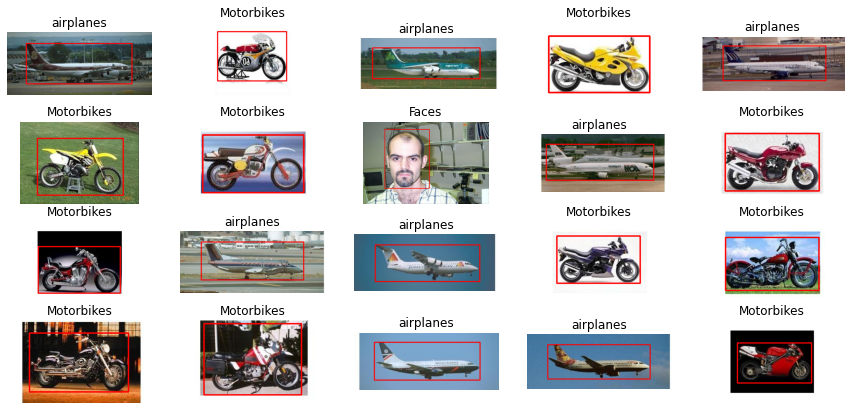

In [22]:
n = 4
m = 5
fig, axs = plt.subplots(n,m, figsize=(15,7))
axs = axs.ravel()
portion = df_annot.sample(n*m, replace=False)
for i in range(len(axs)):
    myhf.show_one(axs[i], portion.iloc[i], 
             dataset_path=photos_dir)

# `STEP 3: PREPROCESSING DATA`
- Resize
- Normlize
- LabelEncode

- ### RESIZE ORIGINAL DATASET

In [23]:
import albumentations as A

resize_pip = A.Compose([A.Resize(300,300,p=1)], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))
# df_resized_annot = myhf.apply_agu_all(df_annot, resize_pip, save_dir=labels_dir, data_path=photos_dir, folder_name='Resized')

# df_resized_annot.to_csv(labels_dir + '/resized_labels.csv', index=False)

In [24]:
df_resized_annot = pd.read_csv(labels_dir + '/resized_labels.csv')
df_resized_annot.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,airplanes/resized_0001.jpg,300,300,airplanes,36,54,263,250
1,airplanes/resized_0002.jpg,300,300,airplanes,44,57,255,249
2,airplanes/resized_0003.jpg,300,300,airplanes,35,65,252,245
3,airplanes/resized_0004.jpg,300,300,airplanes,35,42,261,248
4,airplanes/resized_0005.jpg,300,300,airplanes,36,30,257,248


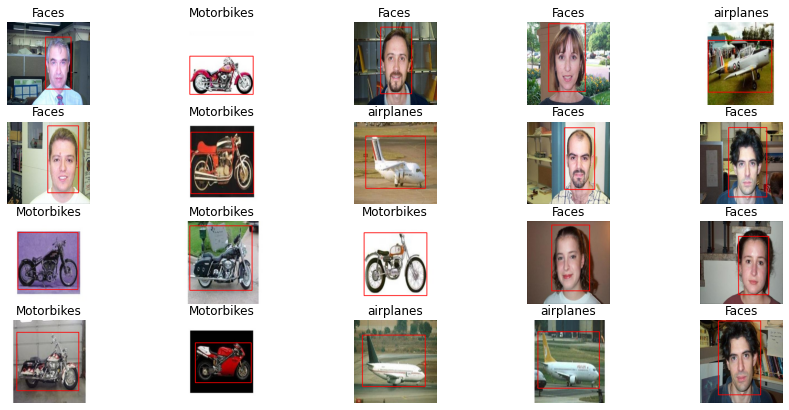

In [26]:
n = 4
m = 5
fig, axs = plt.subplots(n,m, figsize=(15,7))
axs = axs.ravel()
portion = df_resized_annot.sample(n*m, replace=False)
for i in range(len(axs)):
    myhf.show_one(axs[i], portion.iloc[i], 
             dataset_path=labels_dir + '/Resized')

- ### LOAD DATASET
- I did also:
    - Normalization
    - LabelEncoding


In [27]:
dataset_dir = labels_dir + '/Resized'
images, cat_labels, bboxes = myhf.load_dataset_and_bboxes(df_resized_annot, dataset_dir, normalize=True)

In [28]:
classes = cat_labels.unique()
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(cat_labels)

In [41]:
ohe = OneHotEncoder(sparse=False)
ohe_labels = ohe.fit_transform(labels.reshape(-1,1))

# `STEP 4: SPLIT DATA`

In [42]:
x_train, x_val, labels_train, labels_val, bbox_train, bbox_val = train_test_split(images, 
                ohe_labels, bboxes, test_size = 0.1, random_state = 43)

In [43]:
x_train.shape, x_val.shape, labels_train.shape, labels_val.shape, bbox_train.shape, bbox_val.shape

((1828, 300, 300, 3),
 (204, 300, 300, 3),
 (1828, 3),
 (204, 3),
 (1828, 4),
 (204, 4))

# `STEP 5: MODELS TRAINING Without AGUMENTATION`

In [44]:
N_model = tf.keras.applications.NASNetMobile(input_shape=(300,300,3), include_top=False, weights='imagenet')
N_model.trainable = False

In [45]:
num_classes = 3

# x_input = InputLayer(input_shape=(300,300,3), name='I')
model_out = N_model(N_model.input, training=False)
gpa = GlobalAveragePooling2D()(model_out)
flatt = Flatten()(gpa)

class_prediction = Dense(256, activation="relu")(flatt)
class_prediction = Dense(128, activation="relu")(class_prediction )
class_prediction = Dropout(0.2)(class_prediction)
class_prediction = Dense(64, activation="relu")(class_prediction)
class_prediction = Dropout(0.2)(class_prediction )
class_prediction = Dense(32, activation="relu")(class_prediction)
class_output = Dense(num_classes, activation='softmax',name="class_output")(class_prediction)

box_output = Dense(256, activation="relu")(flatt)
box_output = Dense(128, activation="relu")(box_output)
box_output = Dropout(0.2)(box_output )
box_output = Dense(64, activation="relu")(box_output)
box_output = Dropout(0.2)(box_output )
box_output = Dense(32, activation="relu")(box_output)
box_output = Dense(4, activation='sigmoid', name= "box_output")(box_output)

nasnet_model = tf.keras.models.Model(inputs=N_model.input, outputs=[box_output, class_output])

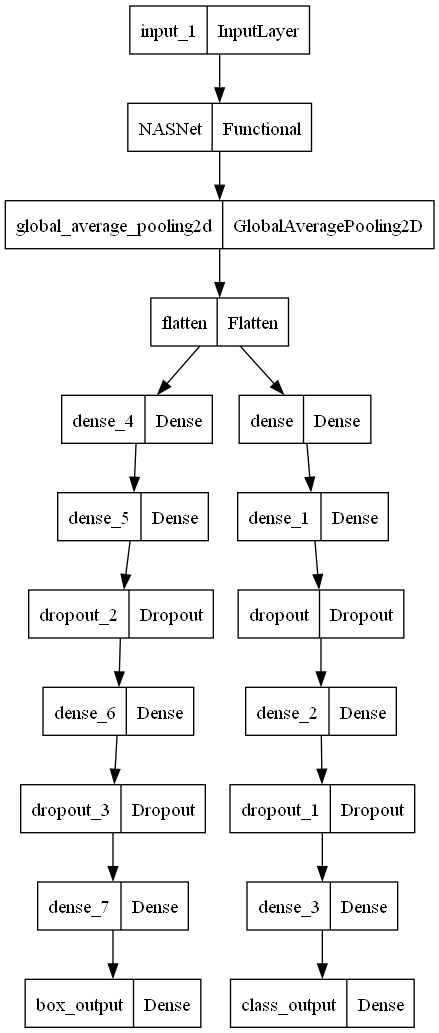

In [46]:
tf.keras.utils.plot_model(nasnet_model, 'nasnet_model.png')

In [47]:
nasnet_model.compile(
  optimizer='adam',
  loss={ 
    "box_output": "mean_squared_error",
    "class_output": "categorical_crossentropy"
    },
  metrics={'class_output': 'accuracy',
          'box_output': 'mean_squared_error'})

In [48]:
trainTargets = {
    "class_output": labels_train,
    "box_output": bbox_train
}
testTargets = {
    "class_output": labels_val,
    "box_output": bbox_val
}
H_nas = nasnet_model.fit(
    x_train, trainTargets,
    validation_data=(x_val, testTargets),
    batch_size=32,
    epochs=20,
    verbose=1)

Epoch 1/20
14/58 [======>.......................] - ETA: 48s - loss: 32741.7363 - box_output_loss: 32741.3887 - class_output_loss: 0.3511 - box_output_mean_squared_error: 32741.3887 - class_output_accuracy: 0.9107

KeyboardInterrupt: 

In [ ]:
# nasnet_model.save('/kaggle/working/NasNet.h5', save_format="h5")

In [ ]:
H_nas.history.keys()

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
myhf.plot(H_nas, 'class_output_accuracy', 'val_class_output_accuracy', 'Class Output Accuracy vs Class Validation Accuracy')

plt.subplot(2,2,2)
myhf.plot(H_nas, 'class_output_loss', 'val_class_output_loss', 'Class Output Loss vs Class Validation Loss')

plt.subplot(2,2,3)
myhf.plot(H_nas, 'box_output_mean_squared_error', 'val_box_output_mean_squared_error', 'Box Output MSE vs Box Validation MSE')

plt.subplot(2,2,4)
myhf.plot(H_nas, 'box_output_loss', 'val_box_output_loss', 'Box Output Loss vs Box Validation Loss')

In [2]:
from keras.applications import VGG16
vgg = VGG16(weights="imagenet", include_top=False, input_shape=(300, 300, 3))
vgg.trainable = False

In [3]:
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(3, activation="softmax", name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
vggnet_model = tf.keras.models.Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

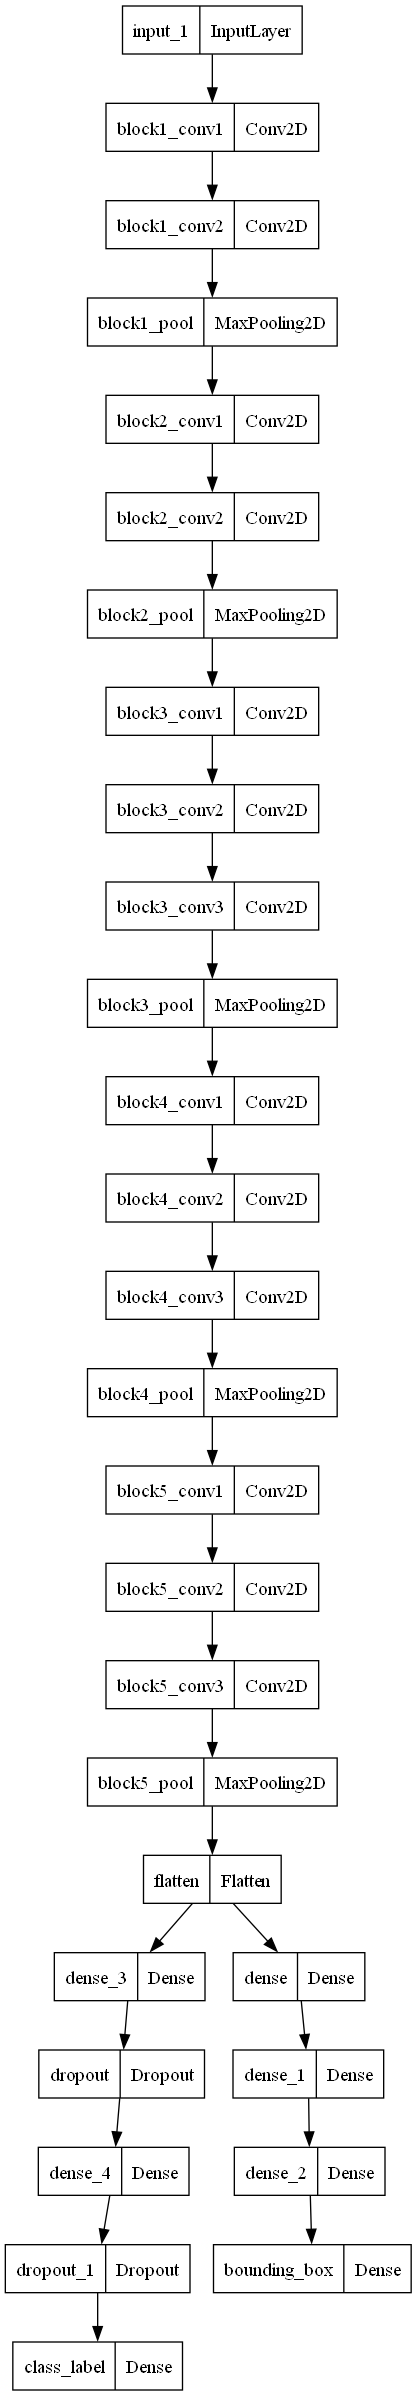

In [5]:
tf.keras.utils.plot_model(vggnet_model, 'vggnet_model.png')

In [46]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}
# opt = Adam(lr=1e-4)
vggnet_model.compile(loss=losses, optimizer='adam',
              metrics={'class_label': 'accuracy', 'bounding_box': 'mean_squared_error'},
              loss_weights=lossWeights)

In [ ]:
trainTargets = {
    "class_label": labels_train,
    "bounding_box": bbox_train
}
testTargets = {
    "class_label": labels_val,
    "bounding_box": bbox_val
}
H_vgg = vggnet_model.fit(
    x_train, trainTargets,
    validation_data=(x_val, testTargets),
    batch_size=32,
    epochs=20,
    verbose=1)

In [ ]:
# vggnet_model.save('/kaggle/working/vgg.h5')

In [ ]:
H_vgg.history.keys()

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
myhf.plot(H_vgg, 'class_label_accuracy', 'val_class_label_accuracy', 'Class Output Accuracy vs Class Validation Accuracy')

plt.subplot(2,2,2)
myhf.plot(H_vgg, 'class_label_loss', 'val_class_label_loss', 'Class Output Loss vs Class Validation Loss')

plt.subplot(2,2,3)
myhf.plot(H_vgg, 'bounding_box_mean_squared_error', 'val_bounding_box_mean_squared_error', 'Box Output MSE vs Box Validation MSE')

plt.subplot(2,2,4)
myhf.plot(H_vgg, 'bounding_box_loss', 'val_bounding_box_loss', 'Box Output Loss vs Box Validation Loss')

# `STEP 6: MODELS Evaluation`

## Without DATA AGUMENTATION

In [ ]:
'''
  train_ds = tf.keras.utils.image_dataset_from_directory(
  'D:/Eng/MLearning/Image-Classification with localization_Project/CALTECH/CALTECH_Dataset',
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(300, 300),
  batch_size=32)
'''

'''
  for image_batch, labels_batch in train_ds:
    image_batch.numpy()
'''